# Image Segmentation with U-Net

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Packages

In [5]:
import os
import imageio
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

## Load Data
* the masked images are stored as png, unmasked (original) as jpg
* the names of these 2 are same so for getting the right sample we can just sort the 2 lists

In [6]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

##Pre-Process Data

In [7]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    print(i_h,i_w,i_c)
    print(m_h,m_w,m_c)

    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.float32)

    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((256,256))
        single_img = np.reshape(single_img,(i_h,i_w,i_c))
        single_img = single_img/256.
        X[index] = single_img

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path).convert('L')
        single_mask = single_mask.resize((256,256))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))
        single_mask = single_mask/256.
        y[index] = single_mask
    return X, y

#Constructing the U-Net Architecture


## U-Net Encoder Block

In [8]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

## U-Net Decoder Block

In [9]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

## Compile U-Net Blocks

In [10]:
def SAUNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output
    """
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size) # Fixed indentation here

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [101]:
def itterUNetCompiled(input_size=(128, 128, 3), n_filters=16, n_classes=3):
    inputs = Input(input_size)

    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

## Load and View Data

In [16]:
!cp "drive/MyDrive/Fundus OCT Dataset.zip" ./

In [17]:
!unzip -q 'Fundus OCT Dataset.zip'

<ipython-input-18-f09512d3efd0>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i])
<ipython-input-18-f09512d3efd0>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 + mask[i])


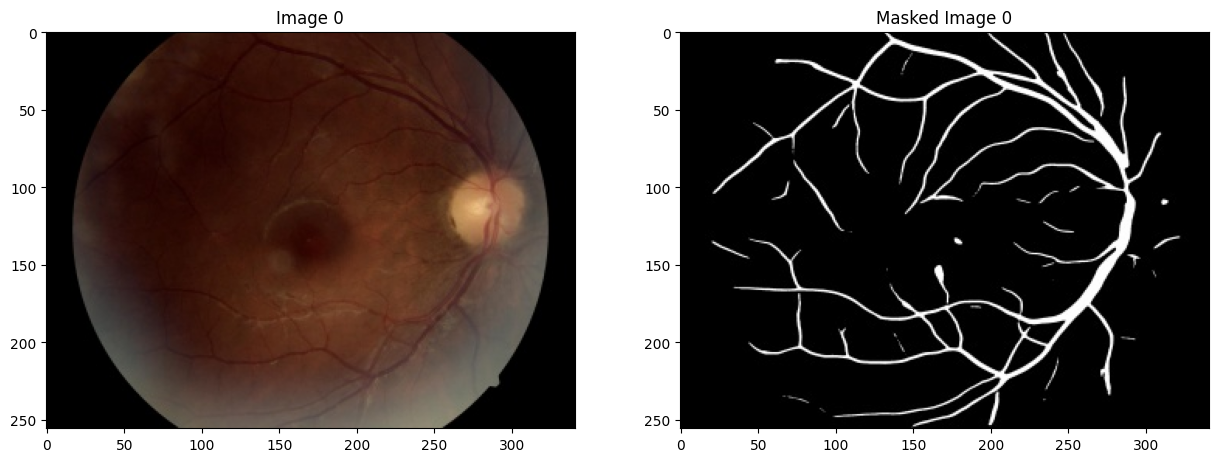

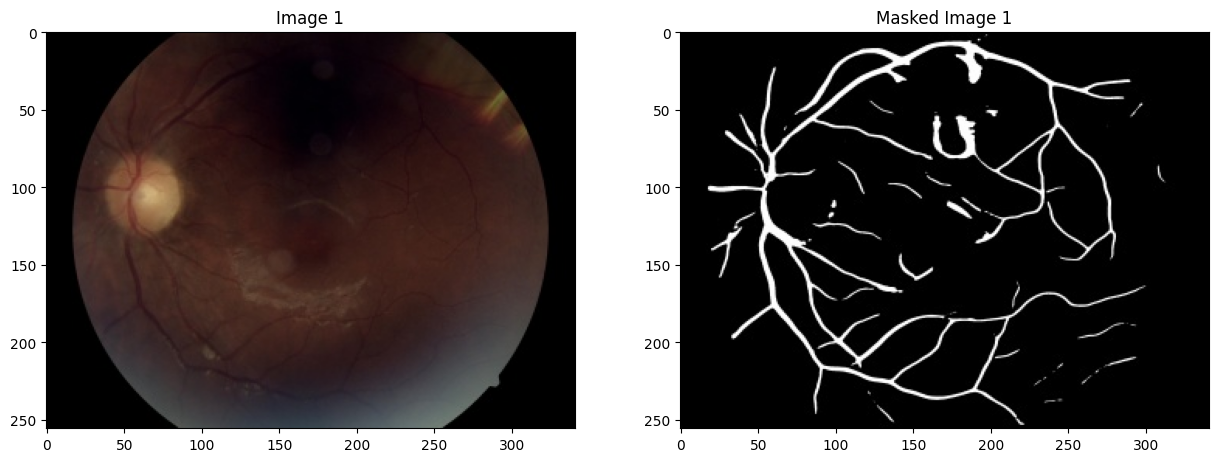

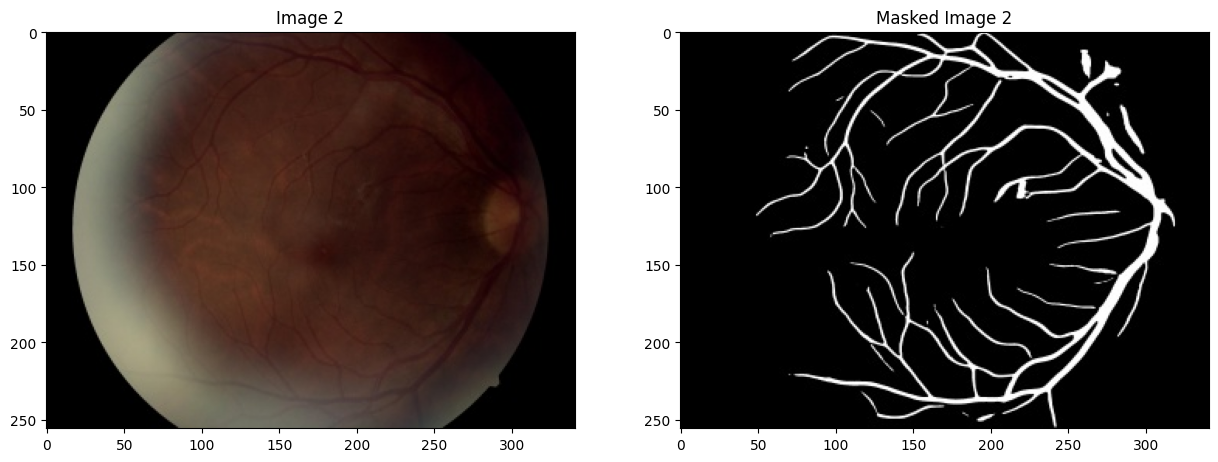

In [18]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = '/content/Fundus OCT Dataset/fundus/'
path2 = '/content/Fundus OCT Dataset/segOCTA/'
img, mask = LoadData (path1, path2)

# View an example of image and corresponding mask
show_images = 3
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

## Process Data

256 256 3
256 256 1


Text(0.5, 1.0, 'Processed Masked Image ')

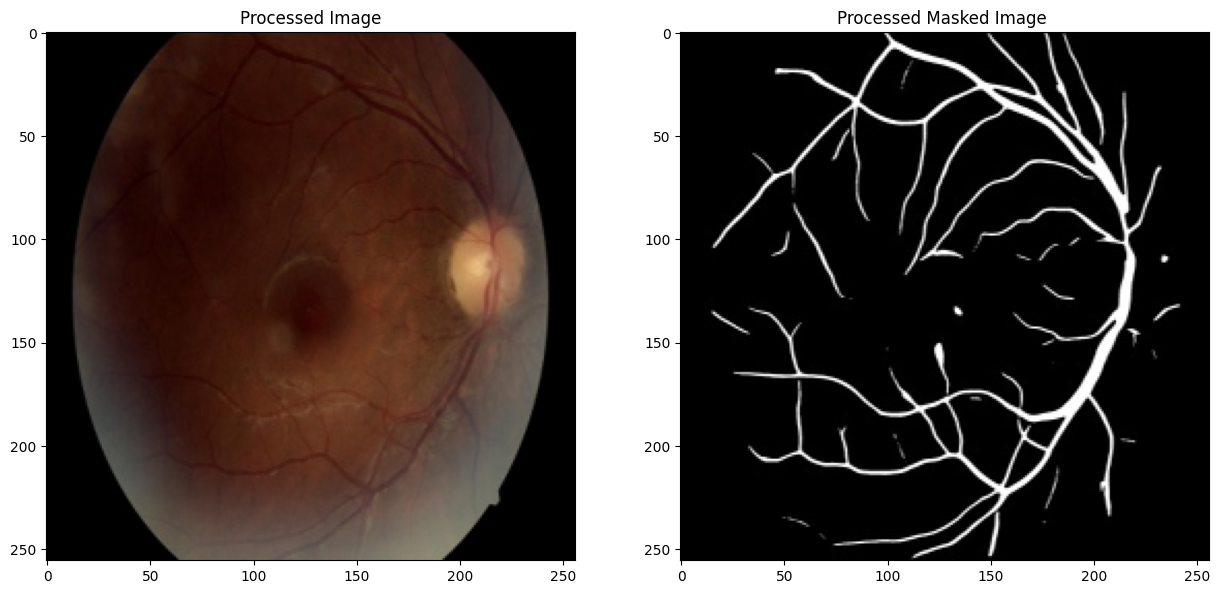

In [19]:
# Define the desired shape
target_shape_img = [256, 256, 3]
target_shape_mask = [256, 256, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index], cmap='gray')
arr[1].set_title('Processed Masked Image ')

## Split Train and Test Set

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=123)

# y_train_reshaped = y_train.reshape(-1, 128 * 128)  # Assuming 128x128 images
# y_valid_reshaped = y_valid.reshape(-1, 128 * 128)  # Assuming 128x128 images


## Build U-Net Architecture

In [103]:
# unet = SAUNetCompiled(input_size=(256,256,3), n_filters=32, n_classes=1)

unet = itterUNetCompiled(input_size=(256,256,3), n_filters=16, n_classes=1)


In [104]:
unet.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_132 (Conv2D)         (None, 256, 256, 16)         448       ['input_8[0][0]']             
                                                                                                  
 conv2d_133 (Conv2D)         (None, 256, 256, 16)         2320      ['conv2d_132[0][0]']          
                                                                                                  
 batch_normalization_53 (Ba  (None, 256, 256, 16)         64        ['conv2d_133[0][0]']          
 tchNormalization)                                                                          

## Compile and Run Model

In [105]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='binary_crossentropy')



results = unet.fit(X_train, y_train, batch_size=32, epochs=70, validation_data=(X_valid, y_valid))

Epoch 1/70
24/24 [==============================] - 37s 644ms/step - loss: 0.3120 - val_loss: 0.2314
Epoch 2/70
24/24 [==============================] - 10s 425ms/step - loss: 0.2371 - val_loss: 0.2293
Epoch 3/70
24/24 [==============================] - 10s 420ms/step - loss: 0.2334 - val_loss: 0.2219
Epoch 4/70
24/24 [==============================] - 10s 416ms/step - loss: 0.2250 - val_loss: 0.2131
Epoch 5/70
24/24 [==============================] - 10s 413ms/step - loss: 0.2215 - val_loss: 0.2232
Epoch 6/70
24/24 [==============================] - 10s 412ms/step - loss: 0.2289 - val_loss: 0.2147
Epoch 7/70
24/24 [==============================] - 10s 415ms/step - loss: 0.2188 - val_loss: 0.2071
Epoch 8/70
24/24 [==============================] - 10s 415ms/step - loss: 0.2128 - val_loss: 0.1988
Epoch 9/70
24/24 [==============================] - 10s 419ms/step - loss: 0.2073 - val_loss: 0.1975
Epoch 10/70
24/24 [==============================] - 10s 417ms/step - loss: 0.2042 - val_lo

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='binary_crossentropy')



results = unet.fit(X_train, y_train, batch_size=8, epochs=50, validation_data=(X_valid, y_valid))

# Evaluate Model Results

## Bias Variance Check

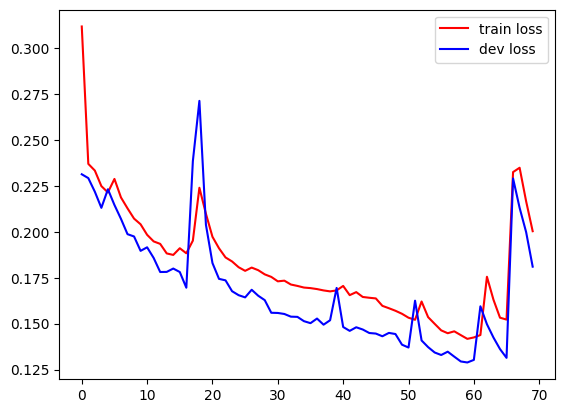

In [106]:
# fig, axis = plt.subplots(1, 2, figsize=(20, 5))
plt.plot(results.history["loss"], color='r', label = 'train loss')
plt.plot(results.history["val_loss"], color='b', label = 'dev loss')
plt.legend()


## View Predicted Segmentations

In [82]:
unet.evaluate(X_valid, y_valid)

2/2 [==============================] - 0s 59ms/step - loss: 0.1105


0.11048732697963715

1/1 [==============================] - 0s 21ms/step


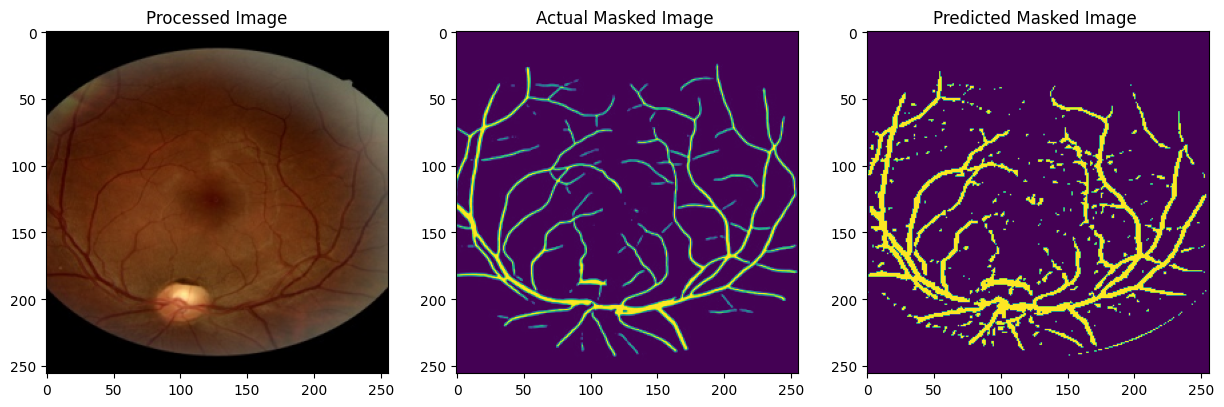

In [110]:
import cv2

# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)


    (_, pred_mask) = cv2.threshold(pred_y[0]*255, 30, 255, cv2.THRESH_BINARY)


    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index] *255)
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask)
    arr[2].set_title('Predicted Masked Image ')


VisualizeResults(3)

In [108]:
print(X[0].shape)
for i in range(len(X)):
  pred_y = unet.predict(X[i][np.newaxis, ...])

  (_, pred_mask) = cv2.threshold(pred_y[0]*255, 20, 255, cv2.THRESH_BINARY)

  cv2.imwrite(f"/content/re/{img[i]}", pred_mask)


(256, 256, 3)
1/1 [==============================] - 0s 33ms/step


In [111]:
!zip -r re.zip re/

updating: re/ (stored 0%)
updating: re/12_OD.jpg (deflated 3%)
updating: re/ccr_52_OD.jpg (deflated 3%)
updating: re/cr_106_OS.jpg (deflated 4%)
updating: re/15_OS.jpg (deflated 3%)
updating: re/92_OD.jpg (deflated 3%)
updating: re/r_73_OD.jpg (deflated 3%)
updating: re/cr_39_OD.jpg (deflated 4%)
updating: re/r_3_OS.jpg (deflated 4%)
updating: re/56_OD.jpg (deflated 3%)
updating: re/cr_93_OD.jpg (deflated 5%)
updating: re/cr_93_OS.jpg (deflated 5%)
updating: re/40_OD.jpg (deflated 4%)
updating: re/cr_10_OS.jpg (deflated 3%)
updating: re/cr_99_OS.jpg (deflated 4%)
updating: re/45_OS.jpg (deflated 3%)
updating: re/ccr_36_OS.jpg (deflated 5%)
updating: re/cr_26_OS.jpg (deflated 3%)
updating: re/86_OD.jpg (deflated 3%)
updating: re/cr_94_OS.jpg (deflated 3%)
updating: re/r_63_OS.jpg (deflated 4%)
updating: re/ccr_40_OD.jpg (deflated 5%)
updating: re/cr_22_OD.jpg (deflated 3%)
updating: re/cr_54_OD.jpg (deflated 3%)
updating: re/98_OD.jpg (deflated 4%)
updating: re/cr_61_OS.jpg (deflated 3%